<a href="https://www.kaggle.com/jzhang233/exercise-machine-learning-competitions?scriptVersionId=89822330" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

In [2]:
print(os.listdir("../input"))

['sample_submission.csv', 'sample_submission.csv.gz', 'train.csv.gz', 'data_description.txt', 'test.csv.gz', 'train.csv', 'test.csv']


In [3]:
# Import helpful libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,r2_score,mean_squared_error,mean_absolute_error,auc,roc_curve,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


In [4]:
# Load the data, and separate the target

train=pd.read_csv('../input/train.csv')

#change this filepath as you need. The path sometimes needs to add '/home-data-for-ml-course/' 

In [5]:
test=pd.read_csv('../input/test.csv')

In [6]:
train.info
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Feature Engineering

In [8]:
#we use a for-loop to see the NA-percentage in each numerical column
for i in train.columns:
    if train[i].isna().any():
        print(i,end='\t')
        print(round(100*train[i].isna().sum()/len(train),2))
        print()


LotFrontage	17.74

Alley	93.77

MasVnrType	0.55

MasVnrArea	0.55

BsmtQual	2.53

BsmtCond	2.53

BsmtExposure	2.6

BsmtFinType1	2.53

BsmtFinType2	2.6

Electrical	0.07

FireplaceQu	47.26

GarageType	5.55

GarageYrBlt	5.55

GarageFinish	5.55

GarageQual	5.55

GarageCond	5.55

PoolQC	99.52

Fence	80.75

MiscFeature	96.3



Apparently some columns have too many missing values. We will drop such features.

In [9]:
#we fill in missing values
for i in train.columns:
    if train[i].isna().any():
        train[i]=train[i].fillna(train[i].mode()[0])
        #don't forget to assign the new col to itself

#The mode of a set of values is the value that appears most often. It can be multiple values.
#by default it returns by column, that is, the most frequent value(s) within one variable

In [10]:
train.isna().any()
#so we have imputed all the missing values

Id               False
MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 81, dtype: bool

In [11]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,223500


In [12]:
test.isna().any()

Id               False
MSSubClass       False
MSZoning          True
LotFrontage       True
LotArea          False
                 ...  
MiscVal          False
MoSold           False
YrSold           False
SaleType          True
SaleCondition    False
Length: 80, dtype: bool

In [13]:
#we do the same operations to our test set
for i in test.columns:
    if test[i].isna().any():
        test[i]=test[i].fillna(test[i].mode()[0])

In [14]:
#we drop variables which have a large percentage of missing values
#because even if we have imputed them, they are still with risks of low efficient infomation
train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature','Id'],inplace=True,axis=1)
#axis=1 for column

In [15]:
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Grvl,Reg,Lvl,AllPub,...,120,0,Ex,MnPrv,Shed,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Ex,MnPrv,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Ex,MnPrv,Shed,0,3,2010,WD,Normal


Because we have so many columns, if we us dummy coding we may have hundreds of columns. 

So in this dataset I consider using labelencoder, simply mapping categorical variables into values.

We apply LabelEncoder in both training set and testing set

In [16]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
for i in train.columns:
    if train[i].dtype=='object':
        train[i]=label.fit_transform(train[i])

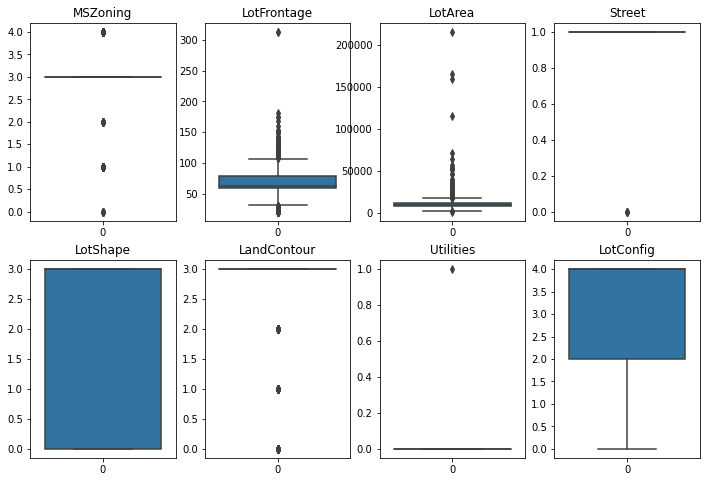

In [17]:
plt.figure(figsize=(12,8))
for i in range(1,9):
    plt.subplot(2,4,i)
    sns.boxplot(data=train.iloc[:,i])
    plt.title(train.columns[i])
#We take a look into our data
#if we don't tranform category variables using LabelEncoder, plots cannot be generated

In [18]:
#We handle the same operation on our test set
#test.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'],inplace=True,axis=1)


label=LabelEncoder()
for i in test.columns:
    if test[i].dtype=='object':
        test[i]=label.fit_transform(test[i])

Later, I want to select variables which have bigger correlation coeffients with our target variable, that is, SalePrice.

We could keep the most correlated ones as our analyzing variables.

In [19]:
cor=train.corr()
r=cor['SalePrice']
abs(r).min()

a=[]
for i in range(len(cor)):
    if r[i]>.3:
        a.append(r.index[i])

a.remove('SalePrice')
a

['LotFrontage',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'Foundation',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

Our trainging set has been cleaned, with nulls imputed and unuseful columns dropped.
In Version 2, I chose the variables which have the greatest correlations with our target variable. The result R^2 of RandomForest is .88, while not eliminating any variables leads to an R^2 larger than 0.9. 

So in Version 3, we will not eliminate variables based on Pearson correlation coefficients.

In [20]:
X=train.iloc[:,:-1]
y=train.iloc[:,-1]
X.shape

(1460, 75)

In choosing between standardscaler and minmaxscaler, the former one seems to be applied to data which follows a normal distribution, while the second should be used in data whose upper and lower boundary are already known.

In this case, we can choose the former method.

In [21]:
scale=StandardScaler()
name=X.columns

X=scale.fit_transform(X)
X=pd.DataFrame(data=X,columns=name)
X.head(3)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.073375,-0.045532,-0.146189,-0.207142,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,...,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.313867,0.208502
1,-0.872563,-0.045532,0.524992,-0.091886,0.064238,0.750731,0.314667,-0.02618,-0.628316,-0.225716,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.313867,0.208502
2,0.073375,-0.045532,-0.011953,0.073480,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,...,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.313867,0.208502


In [22]:
y.head(3)

0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64

In [23]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=.2,random_state=4)


# Model Selection and Fitting

In [24]:

import warnings
warnings.filterwarnings("ignore")

In [25]:
def mypredict(model):
    model.fit(xtrain,ytrain)
    ypred=model.predict(xtest)
    return r2_score(ytest,ypred),mean_absolute_error(ytest,ypred)

model1=RandomForestRegressor(n_estimators=100, criterion='mae')
model2=DecisionTreeRegressor()
model3=XGBRegressor()
model4=LGBMRegressor(n_jobs=-1)
model5=LinearRegression()


models=[model1,model2,model3,model4,model5]
d={'model':[],'R^2':[],'MAE':[]}

for i in models:
    
    d['model'].append(i)
    d['R^2'].append(mypredict(i)[0])
    d['MAE'].append(mypredict(i)[1])
    
df=pd.DataFrame(d)
df

,model,R^2,MAE
0,(DecisionTreeRegressor(criterion='absolute_err...,0.885687,16694.765342
1,DecisionTreeRegressor(),0.710476,26124.835616
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.858292,18203.093028
3,LGBMRegressor(),0.888232,16125.786571
4,LinearRegression(),0.862744,19612.250818


In [26]:
df.iloc[0,:]

model    (DecisionTreeRegressor(criterion='absolute_err...
R^2                                               0.885687
MAE                                           16694.765342
Name: 0, dtype: object

I don't know why my RandomForest printed as DecisionTree.

In the best performed model is our LGBMRegressor.

# Make a Prediction



Now, we read the file of "test" data, and apply our model to make predictions.

In [27]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,2,80.0,11622,1,0,3,3,0,...,120,0,0,2,2,0,6,2010,8,4
1,1462,20,3,81.0,14267,1,0,0,3,0,...,0,0,0,2,0,12500,6,2010,8,4
2,1463,60,3,74.0,13830,1,0,0,3,0,...,0,0,0,2,2,0,3,2010,8,4
3,1464,60,3,78.0,9978,1,0,0,3,0,...,0,0,0,2,2,0,6,2010,8,4
4,1465,120,3,43.0,5005,1,0,0,1,0,...,144,0,0,2,2,0,1,2010,8,4


In [28]:
test.isna().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
                 ...  
MiscVal          False
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
Length: 80, dtype: bool

In [29]:
testid=test['Id']
testid.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

In [30]:
import copy
testcopy=copy.deepcopy(test)

In [31]:

test.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature','Id'],inplace=True,axis=1)


In [32]:
test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80.0,11622,1,3,3,0,4,0,...,0,0,0,120,0,0,6,2010,8,4
1,20,3,81.0,14267,1,0,3,0,0,0,...,36,0,0,0,0,12500,6,2010,8,4
2,60,3,74.0,13830,1,0,3,0,4,0,...,34,0,0,0,0,0,3,2010,8,4


In [33]:
Xpred=scale.transform(test)
Xpred=pd.DataFrame(Xpred,columns=test.columns)
#we transform our test data to make predictions
#Note: in test data, we only need to do transform, not fit!!

In [34]:
Xpred.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.872563,-1.628309,0.524992,0.110763,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,...,-0.704483,-0.359325,-0.116339,1.882709,-0.068692,-0.087688,-0.119110,1.64521,0.313867,0.208502
1,-0.872563,-0.045532,0.569737,0.375850,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,...,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,25.116309,-0.119110,1.64521,0.313867,0.208502
2,0.073375,-0.045532,0.256520,0.332053,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,...,-0.191147,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,1.64521,0.313867,0.208502


In [35]:
ypred=model4.predict(Xpred)

final=pd.DataFrame(data={'Id':testid,'SalePrice':ypred})
final.head()

,Id,SalePrice
0,1461,131081.775619
1,1462,156847.110826
2,1463,185901.670842
3,1464,180422.174440
4,1465,184844.135162


Before submitting, run a check to make sure your `test_preds` have the right format.

# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [36]:
# Run the code to save predictions in the format used for competition scoring

final.to_csv('submission_housingpricePred0311.csv',index=False)

I still have a question that how to better treat those variables. What I did is dropping some cols and fill in na values, as well as using labelencoder to mapping category variables into numbers so that computer could treat with them. But how should we select the variables which are with the greatest importance?

Later, I may try other selection methods like SelectKBest, or embedded methods (such as LASSO), or wrapped methods, or to drop covariates which have multicollinearity.

Below are from Kaggle's tutorial and I keep them unchanged.

#### Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


#### Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


#### What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*